In [ ]:
conda activate TFgpu

In [ ]:
# conda activate PyTorchGPU

<div align="center">
  <img src="DisplayIMG/Cartoon.png" alt="Image Description" />
</div>

In [ ]:
num_cores = os.cpu_count()  # Get number of CPU cores
num_cores_to_use = num_cores // 2  # Use half of the cores

num_cores

In [ ]:
num_cores_to_use

# Full Model before updates

In [1]:
current_directory

NameError: name 'current_directory' is not defined

In [2]:
current_directory = os.getcwd()

NameError: name 'os' is not defined

In [ ]:
import cv2
import os
import numpy as np
from PIL import Image
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import glob
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from keras_tuner import BayesianOptimization, HyperParameters
import pickle

# Get the current directory
current_directory = os.getcwd()

# Specify the folder name where the images are located
folder_name = "img"

# Construct the folder path
folder_path = os.path.join(current_directory, folder_name)

# Specify the CSV file path containing image labels
csv_file_path = os.path.join(current_directory, "labels", "english-clean.csv")

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Create a dictionary where keys are filenames and values are labels
labels_dict = df.set_index('image')['label'].to_dict()


def load_images_from_folder(folder, labels_dict):
    images = []
    labels = []
    for file_path in glob.glob(os.path.join(folder, "*.png")):
        img = Image.open(file_path)
        if img is not None:
            img = img.convert('L')  # Convert image to grayscale
            img = img.resize((64, 64))  # Resize the image                   Ask about this --- Size of image being read?
            np_img = np.array(img)
            images.append(np_img)
            filename = os.path.basename(file_path)
            label = labels_dict[filename]  # Get the label from the filename
            labels.append(label)
    return images, labels

images, labels = load_images_from_folder(folder_path, labels_dict)

le = preprocessing.LabelEncoder()
numerical_labels = le.fit_transform(labels)  # Convert labels to integers

images = np.array(images)  # Convert list of arrays to a single array
mean = np.mean(images)
std = np.std(images)
images = (images - mean) / std  # Normalize pixel values
images = images.reshape(-1, 64, 64, 1)  # Reshape array for CNN

encoded_labels = to_categorical(numerical_labels)  # One-hot encode labels

X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42,
                                                    shuffle=True)

# Data augmentation for training data      #Ask about this - Working with numbers/letters (thinking shear could be problamatic?)

datagen = ImageDataGenerator(                                                     
    rotation_range=35,  # Rotate images randomly by 20 degrees
    width_shift_range=0.1,  # Shift images horizontally by 10% of the width
    height_shift_range=0.1,  # Shift images vertically by 10% of the height
    shear_range=0.0,  # Apply shear transformation with a shear intensity of 0.2
    zoom_range=0.1,  # Apply zoom transformation with a zoom range of 0.2
    horizontal_flip=False,  # Flip images horizontally
    vertical_flip=False  # Do not flip images vertically
)

datagen.fit(X_train)

# Specify the file path to save the best hyperparameters
hyperparameters_file_path = 'best_hyperparameters.pkl'

def build_model(hp):                              
    model = Sequential()     
                                

    # First block of convolutions
    model.add(Conv2D(hp.Int('conv_1_units', min_value=32, max_value=128, step=32),
                     (3, 3),
                     activation='relu',
                     input_shape=(64, 64, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))

    # Second block of convolutions
    model.add(Conv2D(hp.Int('conv_2_units', min_value=64, max_value=256, step=64),
                     (3, 3),
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_1_units', min_value=128, max_value=512, step=128), activation='relu'))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(len(le.classes_), activation='softmax'))

    # Compile model
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

tuner = BayesianOptimization(                                          
    build_model,  # The function to construct the model
    objective='val_accuracy',  # The metric to be optimized
    max_trials=5,  # The maximum number of iterations for tuning
    executions_per_trial=1,  # The number of models that should be built and fit for each trial for robustness purposes
    directory=os.path.normpath('C:/keras_tuning'),  # The path to the directory where the search results are stored
    project_name='keras_tuner_demo',  # The name of the project. This will be the name of the subdirectory under `directory` where the results are saved
    overwrite=True  # Whether or not to overwrite the project if it already exists
)

tuner.search_space_summary()

tuner.search(
    X_train,  # Training data
    y_train,  # Training labels
    epochs=5,  # The number of epochs for training
    validation_data=(X_test, y_test),  # Validation data
    callbacks=[early_stopping, model_checkpoint]  # Callbacks to be used during training
)

tuner.results_summary()

# Save the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0]
with open(hyperparameters_file_path, 'wb') as file:
    pickle.dump(best_hyperparameters.values, file)

    # Load the saved hyperparameters
with open(hyperparameters_file_path, 'rb') as file:
    loaded_hyperparameters_dict = pickle.load(file)
    
# Create a new HyperParameters object and set the loaded hyperparameters
loaded_hyperparameters = HyperParameters()
loaded_hyperparameters.values = loaded_hyperparameters_dict

# Build and train the model with the loaded hyperparameters and augmented data
best_model = build_model(loaded_hyperparameters)
history = best_model.fit(datagen.flow(X_train, y_train),  # Use the augmented data generator for training data
                         steps_per_epoch=len(X_train) // 32,  # Adjust the steps per epoch based on augmented data size
                         epochs=50,
                         validation_data=(X_test, y_test),
                         callbacks=[early_stopping, model_checkpoint])



# Remove Hypertuning

In [ ]:
# import cv2
# import os
# import numpy as np
# from PIL import Image
# import pandas as pd
# from sklearn import preprocessing
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.optimizers import Adam
# import glob
# from sklearn.metrics import classification_report
# import matplotlib.pyplot as plt
# import tensorflow as tf
# import pickle

# # Get the current directory
# current_directory = os.getcwd()

# # Specify the folder name where the images are located
# folder_name = "img"

# # Construct the folder path
# folder_path = os.path.join(current_directory, folder_name)

# # Specify the CSV file path containing image labels
# csv_file_path = os.path.join(current_directory, "labels", "english-clean.csv")

# # Read the CSV file into a DataFrame
# df = pd.read_csv(csv_file_path)

# # Create a dictionary where keys are filenames and values are labels
# labels_dict = df.set_index('image')['label'].to_dict()


# def load_images_from_folder(folder, labels_dict):
#     images = []
#     labels = []
#     for file_path in glob.glob(os.path.join(folder, "*.png")):
#         img = Image.open(file_path)
#         if img is not None:
#             img = img.convert('L')  # Convert image to grayscale
#             img = img.resize((64, 64))  # Resize the image
#             np_img = np.array(img)
#             images.append(np_img)
#             filename = os.path.basename(file_path)
#             label = labels_dict[filename]  # Get the label from the filename
#             labels.append(label)
#     return images, labels

# images, labels = load_images_from_folder(folder_path, labels_dict)

# le = preprocessing.LabelEncoder()
# numerical_labels = le.fit_transform(labels)  # Convert labels to integers

# images = np.array(images)  # Convert list of arrays to a single array
# mean = np.mean(images)
# std = np.std(images)
# images = (images - mean) / std  # Normalize pixel values
# images = images.reshape(-1, 64, 64, 1)  # Reshape array for CNN

# encoded_labels = to_categorical(numerical_labels)  # One-hot encode labels

# X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42,
#                                                     shuffle=True)

# # Data augmentation for training data
# datagen = ImageDataGenerator(                                                     
#     rotation_range=35,  # Rotate images randomly by 20 degrees
#     width_shift_range=0.1,  # Shift images horizontally by 10% of the width
#     height_shift_range=0.1,  # Shift images vertically by 10% of the height
#     shear_range=0.0,  # Apply shear transformation with a shear intensity of 0.2
#     zoom_range=0.1,  # Apply zoom transformation with a zoom range of 0.2
#     horizontal_flip=False,  # Flip images horizontally
#     vertical_flip=False  # Do not flip images vertically
# )

# datagen.fit(X_train)

# # Build the model
# model = Sequential()     

# # First block of convolutions
# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))

# # Second block of convolutions
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))

# # Fully connected layers
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(len(le.classes_), activation='softmax'))

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Set up callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

# # Train the model
# history = model.fit(datagen.flow(X_train, y_train),
#                     steps_per_epoch=len(X_train) // 32,
#                     epochs=50,
#                     validation_data=(X_test, y_test),
#                     callbacks=[early_stopping, model_checkpoint])


# VGG16 Model

In [5]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

    

Please install GPU version of TF


In [3]:
import cv2
import os
import numpy as np
from PIL import Image
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import glob
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf

# Get the current directory
current_directory = os.getcwd()

# Specify the folder name where the images are located
folder_name = "img"

# Construct the folder path
folder_path = os.path.join(current_directory, folder_name)

# Specify the CSV file path containing image labels
csv_file_path = os.path.join(current_directory, "labels", "english-clean.csv")

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Create a dictionary where keys are filenames and values are labels
labels_dict = df.set_index('image')['label'].to_dict()


def load_images_from_folder(folder, labels_dict):
    images = []
    labels = []
    for file_path in glob.glob(os.path.join(folder, "*.png")):
        img = Image.open(file_path)
        if img is not None:
            img = img.resize((224, 224))  # Resize the image to match VGG16 input size
            np_img = np.array(img)
            images.append(np_img)
            filename = os.path.basename(file_path)
            label = labels_dict[filename]  # Get the label from the filename
            labels.append(label)
    return images, labels

images, labels = load_images_from_folder(folder_path, labels_dict)

le = preprocessing.LabelEncoder()
numerical_labels = le.fit_transform(labels)  # Convert labels to integers

images = np.array(images)  # Convert list of arrays to a single array
mean = np.mean(images)
std = np.std(images)
images = (images - mean) / std  # Normalize pixel values
images = images.reshape(-1, 224, 224, 3)  # Reshape array for VGG16 (RGB input)

encoded_labels = to_categorical(numerical_labels)  # One-hot encode labels

X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42,
                                                    shuffle=True)

# Data augmentation for training data
datagen = ImageDataGenerator(
    rotation_range=35,  # Rotate images randomly by 20 degrees
    width_shift_range=0.1,  # Shift images horizontally by 10% of the width
    height_shift_range=0.1,  # Shift images vertically by 10% of the height
    shear_range=0.0,  # Apply shear transformation with a shear intensity of 0.2
    zoom_range=0.1,  # Apply zoom transformation with a zoom range of 0.2
    horizontal_flip=False,  # Flip images horizontally
    vertical_flip=False  # Do not flip images vertically
)

datagen.fit(X_train)

# Define the VGG16 model structure
def create_model(input_shape, num_classes):
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Classification block
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model

input_shape = (224, 224, 3)
num_classes = len(le.classes_)
model = create_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(datagen.flow(X_train, y_train),
                    steps_per_epoch=len(X_train) // 32,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint])


Epoch 1/50
85/85 [==============================] - 231s 3s/step - loss: 6.0157 - accuracy: 0.0126 - val_loss: 4.1294 - val_accuracy: 0.0073
Epoch 2/50
85/85 [==============================] - 223s 3s/step - loss: 4.1276 - accuracy: 0.0148 - val_loss: 4.1307 - val_accuracy: 0.0073
Epoch 3/50
85/85 [==============================] - 222s 3s/step - loss: 4.1272 - accuracy: 0.0156 - val_loss: 4.1319 - val_accuracy: 0.0073
Epoch 4/50
85/85 [==============================] - 225s 3s/step - loss: 4.1271 - accuracy: 0.0189 - val_loss: 4.1338 - val_accuracy: 0.0088
Epoch 5/50
85/85 [==============================] - 227s 3s/step - loss: 4.1270 - accuracy: 0.0182 - val_loss: 4.1344 - val_accuracy: 0.0073
Epoch 6/50
85/85 [==============================] - 222s 3s/step - loss: 4.1267 - accuracy: 0.0167 - val_loss: 4.1362 - val_accuracy: 0.0073
Epoch 7/50
85/85 [==============================] - 223s 3s/step - loss: 4.1264 - accuracy: 0.0156 - val_loss: 4.1370 - val_accuracy: 0.0073
Epoch 8/50
85

In [ ]:
import os
import glob
import torch
import numpy as np
from PIL import Image

In [3]:
python -c "import torch; print(torch.cuda.is_available())"


SyntaxError: invalid syntax (2608241997.py, line 1)

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# import os
# import glob
# import torch
# import numpy as np
# from PIL import Image
# import pandas as pd
# from sklearn import preprocessing
# from sklearn.model_selection import train_test_split
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, Dataset
# from torchvision import transforms
# from torch.autograd import Variable

# # Get the current directory
# current_directory = os.getcwd()

# # Specify the folder name where the images are located
# folder_name = "img"

# # Construct the folder path
# folder_path = os.path.join(current_directory, folder_name)

# # Specify the CSV file path containing image labels
# csv_file_path = os.path.join(current_directory, "labels", "english-clean.csv")

# # Read the CSV file into a DataFrame
# df = pd.read_csv(csv_file_path)

# # Create a dictionary where keys are filenames and values are labels
# labels_dict = df.set_index('image')['label'].to_dict()

# def load_images_from_folder(folder, labels_dict):
#     images = []
#     labels = []
#     for file_path in glob.glob(os.path.join(folder, "*.png")):
#         img = Image.open(file_path)
#         if img is not None:
#             img = img.resize((224, 224))  # Resize the image to match VGG16 input size
#             images.append(np.array(img))
#             filename = os.path.basename(file_path)
#             label = labels_dict[filename]  # Get the label from the filename
#             labels.append(label)
#     return images, labels

# images, labels = load_images_from_folder(folder_path, labels_dict)

# le = preprocessing.LabelEncoder()
# numerical_labels = le.fit_transform(labels)  # Convert labels to integers

# images = np.array(images)  # Convert list of arrays to a single array
# images = images / 255.0  # Normalize pixel values to [0, 1]

# X_train, X_test, y_train, y_test = train_test_split(images, numerical_labels, test_size=0.2, random_state=42,
#                                                     shuffle=True)

# X_train = torch.from_numpy(X_train).permute(0, 3, 1, 2).float()  # Convert to PyTorch tensors
# X_test = torch.from_numpy(X_test).permute(0, 3, 1, 2).float()
# y_train = torch.from_numpy(y_train).long()
# y_test = torch.from_numpy(y_test).long()

# # Define the VGG16 model structure
# class VGG16(nn.Module):
#     def __init__(self, num_classes):
#         super(VGG16, self).__init__()

#         self.features = nn.Sequential(
#             # Block 1
#             nn.Conv2d(3, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             # Block 2
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             # Block 3
#             nn.Conv2d(128, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             # Block 4
#             nn.Conv2d(256, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             # Block 5
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )

#         self.classifier = nn.Sequential(
#             nn.Linear(512 * 7 * 7, 4096),
#             nn.ReLU(True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(True),
#             nn.Dropout(),
#             nn.Linear(4096, num_classes),
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         return x

# model = VGG16(len(le.classes_))

# # Define the loss function and the optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training loop
# for epoch in range(50):  # loop over the dataset multiple times
#     running_loss = 0.0
#     for i, data in enumerate(zip(X_train, y_train), 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data

#         # wrap them in Variable
#         inputs, labels = Variable(inputs.unsqueeze(0)), Variable(labels.unsqueeze(0))

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:  # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0

# print('Finished Training')



In [4]:
device

device(type='cuda')

In [1]:
CUDA_LAUNCH_BLOCKING=1

In [2]:
import os
import glob
import torch
import numpy as np
from PIL import Image
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim

# Enable device-side assertions
os.environ["TORCH_USE_CUDA_DSA"] = "1"

# Get the current directory
current_directory = os.getcwd()

# Specify the folder name where the images are located
folder_name = "img"

# Construct the folder path
folder_path = os.path.join(current_directory, folder_name)

# Specify the CSV file path containing image labels
csv_file_path = os.path.join(current_directory, "labels", "english-clean.csv")

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Create a dictionary where keys are filenames and values are labels
labels_dict = df.set_index('image')['label'].to_dict()

def load_images_from_folder(folder, labels_dict):
    images = []
    labels = []
    for file_path in glob.glob(os.path.join(folder, "*.png")):
        img = Image.open(file_path)
        if img is not None:
            img = img.resize((224, 224))  # Resize the image to match VGG16 input size
            images.append(np.array(img))
            filename = os.path.basename(file_path)
            label = labels_dict[filename]  # Get the label from the filename
            labels.append(label)
    return images, labels

images, labels = load_images_from_folder(folder_path, labels_dict)

le = preprocessing.LabelEncoder()
numerical_labels = le.fit_transform(labels)  # Convert labels to integers

images = np.array(images)  # Convert list of arrays to a single array
images = images / 255.0  # Normalize pixel values to [0, 1]

X_train, X_test, y_train, y_test = train_test_split(images, numerical_labels, test_size=0.2, random_state=42,
                                                    shuffle=True)

X_train = torch.from_numpy(X_train).permute(0, 3, 1, 2).float()  # Convert to PyTorch tensors
X_test = torch.from_numpy(X_test).permute(0, 3, 1, 2).float()
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

# Define the VGG16 model structure
class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.flatten(start_dim=1)  # Flatten the tensor
        x = self.classifier(x)
        return x

model = VGG16(len(le.classes_))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set CUDA_LAUNCH_BLOCKING=1 for synchronous CUDA error reporting
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Training loop
for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    for i, data in enumerate(zip(X_train, y_train), 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # move them to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.unsqueeze(0))
        loss = criterion(outputs, labels.unsqueeze(0))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += 1  # Increment total_samples by 1

        total_correct += (predicted == labels).sum().item()

        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000), flush=True)
            running_loss = 0.0

    # Calculate and print validation accuracy after each epoch
    with torch.no_grad():
        model.eval()
        outputs = model(X_test.to(device))
        _, predicted = torch.max(outputs.data, 1)

        print("Debug: Predicted shape", predicted.shape)
        print("Debug: y_test shape", y_test.shape)
        print("Debug: Predicted device", predicted.device)
        print("Debug: y_test device", y_test.device)

        try:
            correct = (predicted == y_test.to(device)).sum().item()
        except Exception as e:
            print("Debug: Exception caught", str(e))
            raise

        accuracy = correct / len(y_test) * 100
        print('Validation Accuracy: %.2f %%' % accuracy, flush=True)
        model.train()

print('Finished Training')

[1,  2000] loss: 4.143


RuntimeError: CUDA error: an illegal memory access was encountered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Question - ways to evaluate the layers of the model?

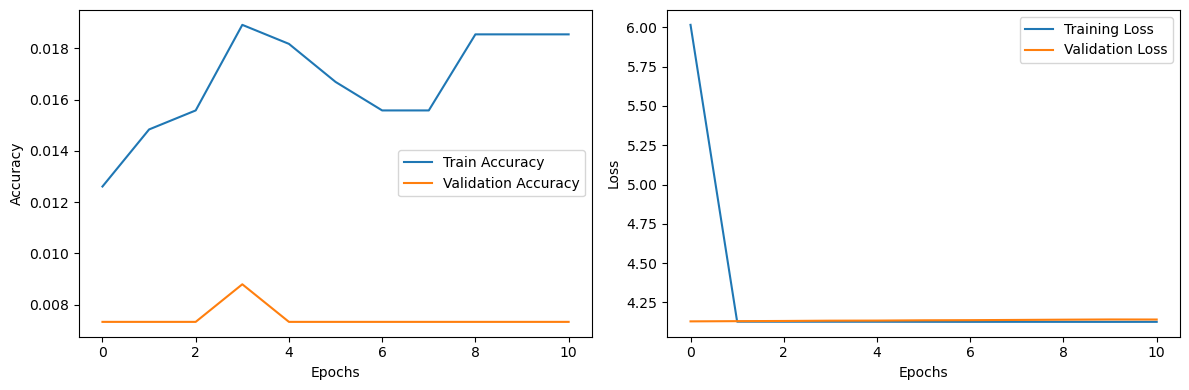

NameError: name 'best_model' is not defined

In [4]:
# Plotting the accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print a classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_, zero_division=1))


In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=[12,8])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=[12,8])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = best_model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test accuracy:", results)

In [ ]:
# #Save Model For Furture Use
# model.save('EpochTenThousand')

In [ ]:
# import pickle

# # Assume you have a history object from model.fit
# # history = model.fit(....)

# # Save it under some name
# with open('trainHistoryDict', 'wb') as file_pi:
#     pickle.dump(history.history, file_pi)


In [ ]:
# with open('trainHistoryDict', 'rb') as file_pi:
#     loaded_history = pickle.load(file_pi)

In [ ]:
# Evaluate the model on the training set
train_loss, train_accuracy = best_model.evaluate(X_train, y_train)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

In [ ]:
# Evaluate the model on the test set
loss, accuracy = best_model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, zero_division=1))

# Print confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)
print("Confusion Matrix:")
print(confusion_mtx)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Convert probabilities to labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Also convert the one-hot encoded labels back to label encoding
y_true_labels = np.argmax(y_test, axis=1)

# Convert numerical labels back to original labels
y_pred_labels = le.inverse_transform(y_pred_labels)
y_true_labels = le.inverse_transform(y_true_labels)

# Calculate confusion matrix
confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

# Create a list of unique labels
labels = list(le.classes_)

# Set the font scale (this will affect heatmap annotation size)
sns.set(font_scale=1.5)

# Adjust size of labels, title using rcParams
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

# Visualize confusion matrix using seaborn's heatmap
plt.figure(figsize=(25, 20))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.title('Confusion Matrix', fontsize=25)
plt.show()


In [ ]:
best_model.summary()

# Class Activation Maps (CAM):

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

def visualize_cam(model, img):
    # Extract the last convolutional layer
    last_conv_layer = model.get_layer('conv2d_2')
    
    # Define a new model that outputs the last conv layer and the model's predicted class probabilities
    cam_model = tf.keras.Model(model.input, (last_conv_layer.output, model.output))
    
    # Calculate the gradients of the predicted class with respect to the output feature map of the last conv layer
    with tf.GradientTape() as tape:
        conv_outputs, predictions = cam_model(img)
        predicted_class = tf.argmax(predictions[0])
        gradient = tape.gradient(predictions[:, predicted_class], conv_outputs)
    
    # Compute the weights using global average pooling on the gradients
    weights = tf.reduce_mean(gradient[0], axis=(0, 1))
    
    # Get the feature map values and resize them to match the input image size
    feature_map = conv_outputs[0]
    cam = np.dot(feature_map, weights)
    cam = cv2.resize(cam, (img.shape[2], img.shape[1]))
    cam = np.maximum(cam, 0)
    
    # Normalize the CAM values if the maximum value is non-zero
    max_value = np.max(cam)
    if max_value != 0:
        cam = cam / max_value
    
    return cam


# Choose an image from the test set
test_image = X_test[4]

# Reshape the image to match the input shape of the model
test_image = np.reshape(test_image, (1, 64, 64, 1))

# Generate the CAM for the chosen image
cam = visualize_cam(best_model, test_image)

# Plot the original image and the CAM
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title('Class Activation Map')

plt.tight_layout()
plt.show()


In [ ]:
def visualize_cam(model, img):
    # Extract the last convolutional layer
    last_conv_layer = model.get_layer('conv2d_3')
    
    # Define a new model that outputs the last conv layer and the model's predicted class probabilities
    cam_model = tf.keras.Model(model.input, (last_conv_layer.output, model.output))
    
    # Calculate the gradients of the predicted class with respect to the output feature map of the last conv layer
    with tf.GradientTape() as tape:
        conv_outputs, predictions = cam_model(img)
        predicted_class = tf.argmax(predictions[0])
        gradient = tape.gradient(predictions[:, predicted_class], conv_outputs)
    
    # Compute the weights using global average pooling on the gradients
    weights = tf.reduce_mean(gradient[0], axis=(0, 1))
    
    # Get the feature map values and resize them to match the input image size
    feature_map = conv_outputs[0]
    cam = np.dot(feature_map, weights)
    cam = cv2.resize(cam, (img.shape[2], img.shape[1]))
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    
    return cam


In [ ]:
cam = visualize_cam(best_model, test_image)

# Plot the original image and the CAM
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title('Class Activation Map')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

def visualize_cam(model, img):
    # Extract the last convolutional layer
    last_conv_layer = model.get_layer('conv2d_2')
    
    # Define a new model that outputs the last conv layer and the model's predicted class probabilities
    cam_model = tf.keras.Model(model.input, (last_conv_layer.output, model.output))
    
    # Calculate the gradients of the predicted class with respect to the output feature map of the last conv layer
    with tf.GradientTape() as tape:
        conv_outputs, predictions = cam_model(img)
        predicted_class = tf.argmax(predictions[0])
        gradient = tape.gradient(predictions[:, predicted_class], conv_outputs)
    
    # Compute the weights using global average pooling on the gradients
    weights = tf.reduce_mean(gradient[0], axis=(0, 1))
    
    # Get the feature map values and resize them to match the input image size
    feature_map = conv_outputs[0]
    cam = np.dot(feature_map, weights)
    cam = cv2.resize(cam, (img.shape[2], img.shape[1]))
    cam = np.maximum(cam, 0)
    
    # Normalize the CAM values if the maximum value is non-zero
    max_value = np.max(cam)
    if max_value != 0:
        cam = cam / max_value
    
    return cam


# Choose an image from the test set
test_image = X_test[10]

# Reshape the image to match the input shape of the model
test_image = np.reshape(test_image, (1, 64, 64, 1))

# Generate the CAM for the chosen image
cam = visualize_cam(best_model, test_image)

# Plot the original image and the CAM
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title('Class Activation Map')

plt.tight_layout()
plt.show()


# Class Activation Maps (CAM) of First Layer

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

def visualize_cam(model, img):
    # Extract the last convolutional layer
    last_conv_layer = model.get_layer('conv2d_2')
    
    # Define a new model that outputs the last conv layer and the model's predicted class probabilities
    cam_model = tf.keras.Model(model.input, (last_conv_layer.output, model.output))
    
    # Reshape the input image to match the expected input shape of the model
    img = np.reshape(img, (-1, 64, 64, 1))
    
    # Calculate the gradients of the predicted class with respect to the output feature map of the last conv layer
    with tf.GradientTape() as tape:
        conv_outputs, predictions = cam_model(img)
        predicted_class = tf.argmax(predictions[0])
        gradient = tape.gradient(predictions[:, predicted_class], conv_outputs)
    
    # Compute the weights using global average pooling on the gradients
    weights = tf.reduce_mean(gradient[0], axis=(0, 1))
    
    # Get the feature map values and resize them to match the input image size
    feature_map = conv_outputs[0]
    cam = np.dot(feature_map, weights)
    cam = cv2.resize(cam, (img.shape[2], img.shape[1]))
    cam = np.maximum(cam, 0)
    
    # Normalize the CAM values if the maximum value is non-zero
    max_value = np.max(cam)
    if max_value != 0:
        cam = cam / max_value
    else:
        # If the maximum value is zero, set all values to zero
        cam = np.zeros_like(cam)
    
    return cam


# Reshape the image to match the expected input shape of the model
test_image = np.reshape(test_image, (64, 64))
test_image = np.expand_dims(test_image, axis=-1)
test_image = np.expand_dims(test_image, axis=0)

cam = visualize_cam(best_model, test_image)

# Plot the original image and the CAM
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title('Class Activation Map')

plt.tight_layout()
plt.show()


# Class Activation Maps (CAM) of 2nd Layer:

In [ ]:
import numpy as np
import tensorflow.keras.backend as K

def visualize_cam(model, img):
    # Extract the last convolutional layer
    last_conv_layer = model.get_layer('conv2d_3')
    
    # Define a new model that outputs the last conv layer and the model's predicted class probabilities
    cam_model = tf.keras.Model(model.input, (last_conv_layer.output, model.output))
    
    # Calculate the gradients of the predicted class with respect to the output feature map of the last conv layer
    with tf.GradientTape() as tape:
        conv_outputs, predictions = cam_model(img)
        predicted_class = tf.argmax(predictions[0])
        gradient = tape.gradient(predictions[:, predicted_class], conv_outputs)
    
    # Compute the weights using global average pooling on the gradients
    weights = tf.reduce_mean(gradient[0], axis=(0, 1))
    
    # Get the feature map values and resize them to match the input image size
    feature_map = conv_outputs[0]
    cam = np.dot(feature_map, weights)
    cam = cv2.resize(cam, (img.shape[2], img.shape[1]))
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    
    return cam


# Choose an image from the test set
test_image = X_test[3]

# Reshape the image to match the input shape of the model
test_image = np.reshape(test_image, (1, 64, 64, 1))

# Generate the CAM for the chosen image
cam = visualize_cam(best_model, test_image)

# Plot the original image and the CAM
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title('Class Activation Map')

plt.tight_layout()
plt.show()


# Grad-CAM:

# Feature Maps:

In [ ]:
def visualize_feature_maps(model, img):
    # Extract the intermediate feature maps
    layer_outputs = [layer.output for layer in model.layers if 'conv2d' in layer.name]
    activation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)

    # Ensure that img is a tensor with consistent shape
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = tf.reshape(img, (1, 64, 64, 1))

    # Predict the feature maps
    feature_maps = activation_model.predict(img, batch_size=1)

    # Plot the feature maps
    for layer, feature_map in zip(model.layers, feature_maps):
        if 'conv2d' in layer.name:
            plt.figure(figsize=(8, 4))
            plt.imshow(feature_map[0, :, :, 0], cmap='gray')
            plt.title(layer.name + ' Feature Map')
            plt.show()

# Visualize the feature maps for the chosen image
visualize_feature_maps(best_model, test_image)


# Filter Visualization:

In [ ]:
def visualize_filters(model, layer_name):
    layer = model.get_layer(layer_name)
    filters, _ = layer.get_weights()

    if filters.ndim == 4:
        filters = np.moveaxis(filters, -1, 0)

    num_filters = filters.shape[0]
    num_rows = (num_filters + 7) // 8
    plt.figure(figsize=(12, num_rows * 1.5))

    for i, filter_ in enumerate(filters):
        plt.subplot(num_rows, 8, i+1)
        plt.imshow(filter_, cmap='gray')
        plt.axis('off')

    plt.suptitle(layer_name + ' Filters')
    plt.tight_layout()
    plt.show()



# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

# Visualize the filters of the first convolutional layer
visualize_filters(best_model, 'conv2d_2')


# Activation Histograms:

In [ ]:
def plot_activation_histograms(model, img):
    activation_model = tf.keras.Model(inputs=model.input,
                                      outputs=[layer.output for layer in model.layers if 'conv2d' in layer.name])
    activations = activation_model.predict(img)

    plt.figure(figsize=(12, 6))
    for i, activation in enumerate(activations):
        if 'conv2d_2' in model.layers[i].name:
            plt.subplot(2, 4, i+1)
            plt.hist(activation.flatten(), bins=50)
            plt.title(model.layers[i].name + ' Activation')
            plt.xlabel('Activation Value')
            plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Plot the activation histograms for the chosen image
plot_activation_histograms(best_model, test_image)


# Learning Curves:

In [ ]:
# Plotting the accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Hyperparameter Optimization:

# Model Architecture Visualization:

# Embedding Visualization:

In [ ]:
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Extract the embeddings from the model
embedding_model = tf.keras.Model(inputs=best_model.input,
                                 outputs=best_model.get_layer('conv2d_2').output)
embeddings = embedding_model.predict(X_test)

# Reshape the embeddings array to have two dimensions
reshaped_embeddings = embeddings.reshape(embeddings.shape[0], -1)

# Standardize the embeddings
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(reshaped_embeddings)

# Reduce the dimensionality of the embeddings using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(scaled_embeddings)

# Plot the embeddings
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=y_true_classes)
plt.colorbar()
plt.title('Embedding Visualization')
plt.show()


In [ ]:
#